# Applying Yields and Resolutions

This notebook serves two purposes. The first is to act as a test; you should be able to roughly reproduce the below graphic by running this notebook. The second is to serve as an example usecase. Below, we want to emulate a detector that we know follows either the Lindhard or Sorenson model for ionization energy and has a resolution that affects where the data lands; we are able to apply both the yields and resolutions to the data in order to get a more realistic model for the detector's output.

![SorVsLin.svg](SorVsLin.svg)

## Generating a \*.root file for this notebook
The file used to generate the above plot is already present. However, if you would like to generate your own file for comparison, you can replace it as follows. In the top-level nrCascadeSim directory, after compiling (and activating any necessary environments if applicable), run:
``` 
bin/realizeCascades -n 10000 -o test-example/data/file.root levelfiles/Si28_ngam_all_cascades.txt
```
(Note that due to the randomness of the output, some variation is expected if you replace the file.)

## Notes

You may encounter some runtime warnings - these are expected.  
If you have a \*.root file you want to call saved to a different location than mentioned in the instructions above, be sure to change line 21 to point to the correct location.  
Please allow sufficient time to run this notebook; for very large root files it could take up to an hour. The provided file should only take a few minutes.

In [1]:
#Import Libraries
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
plt.style.use('standard.mplstyle')
from matplotlib.lines import Line2D
#Custom libraries
import sys
sys.path.append('./python')
import nc_kinematics as nck
import lindhard as lin
import R68_yield as R68y
from hist import histogramable as h

#Build stuff!

#Select a file.
file = './data/file.root'

real_Lind = np.ndarray.flatten(np.asarray(h(file)[0]))
real_Sor = np.ndarray.flatten(np.asarray(h(file,model='Sorenson')[0]))

#You may change the scalefactor to alter the width of the resolution. 
#The number multiplies the width of the Gaussian,
#So a higher number will mean the resolution has more of an effect on the data.
resolution_scale = 0.2
small_Lind = np.ndarray.flatten(np.asarray(h(file,scalefactor=resolution_scale)[0]))
small_Sor = np.ndarray.flatten(np.asarray(h(file,model='Sorenson',scalefactor=resolution_scale)[0]))

real_Lind = real_Lind[real_Lind >= 0]
real_Sor = real_Sor[real_Sor >= 0]
small_Lind = small_Lind[small_Lind >= 0]
small_Sor = small_Sor[small_Sor >= 0]

#From https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis

def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = np.float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

dict_keys(['xx', 'yy', 'ex', 'ey'])


/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


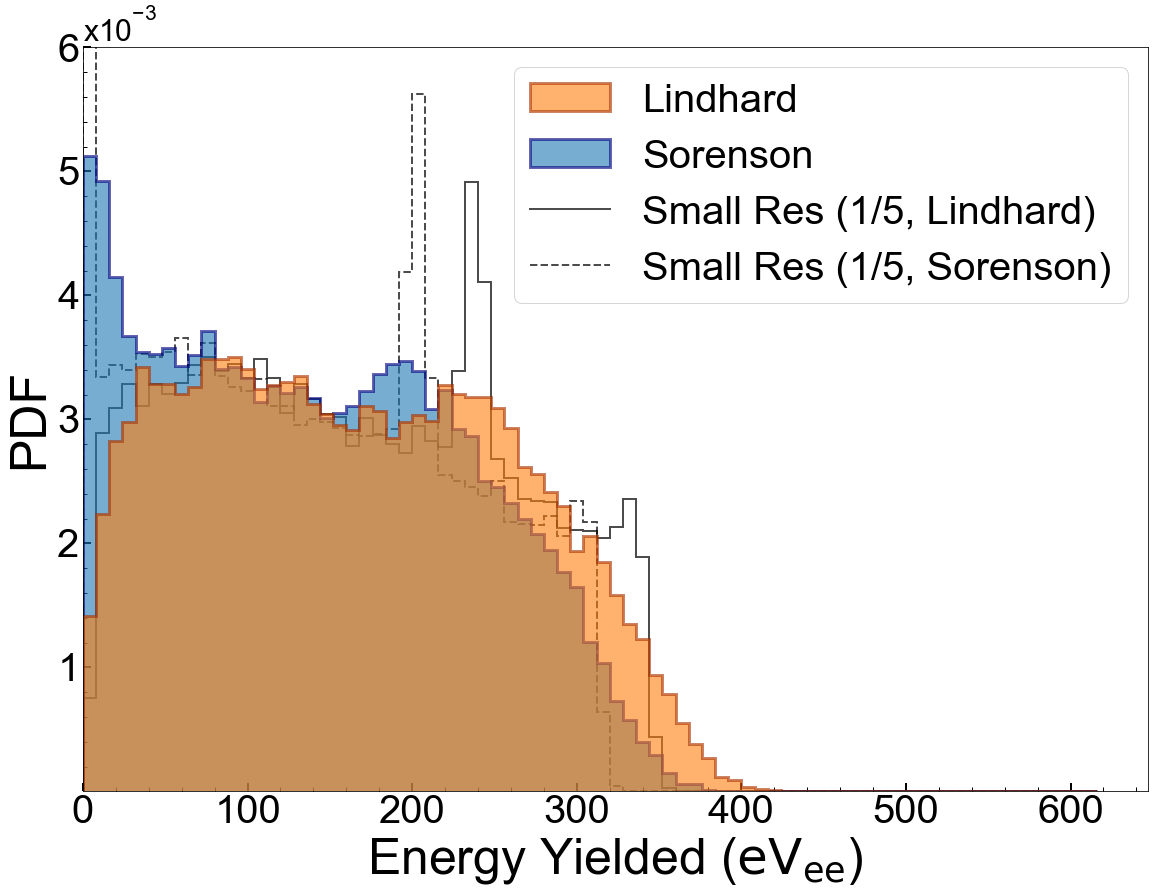

In [2]:
fig, ax = plt.subplots(figsize=(16,12))

binsize = 8 #bin width in eVee
bins = np.arange(0,620,binsize)

plt.hist(small_Lind,alpha=0.7,label='Small Res (1/5, Lindhard)',histtype='step',edgecolor='black',density='True',linewidth=2,bins=bins)
plt.hist(small_Sor,alpha=0.7,label='Small Res (1/5, Sorenson)',histtype='step',edgecolor='black',linestyle='--',density='True',linewidth=2,bins=bins)
plt.hist(real_Sor,alpha=0.6,label='Sorenson',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')
plt.hist(real_Lind,alpha=0.6,label='Lindhard',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')

plt.xlabel(r"Energy Yielded ($\mathrm{eV}_{\mathrm{ee}}$)",fontsize=50)
plt.ylabel("PDF",fontsize=50)#Counts/(total counts * bin width)")

ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major',labelsize=40)

plt.xlim([0,None])
plt.ylim([6e-13,6e-3]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away

#Legend
LindPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='Lindhard',alpha=0.6)
SorPatch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='Sorenson',alpha=0.6)
LindLine = Line2D([0],[0],alpha=0.7,color='black',label='Small Res (1/5, Lindhard)')
SorLine = Line2D([0],[0],linestyle='--',alpha=0.7,color='black',label='Small Res (1/5, Sorenson)')

plt.legend(handles=[LindPatch,SorPatch,LindLine,SorLine],fontsize=40)
plt.show()

NOTE: values < 0 were manually removed. The resolution model generates a gaussian with a width which is proportionately larger for smaller values of E, resulting in (non-physically) negative values in the results. 